建立一个逻辑回归模型来预测一个学生是否能够被大学录取。数据集是包含大量的历史申请人的考试信息和录取情况，大学会根据每个申请人的两次考试成绩决定是否录取。模型建立好后，能够根据新的申请人的考试信息预测是否录取。0表示未被录取，1表示被录取了


这里再简要说一下线性回归和逻辑回归中的损失函数。
首先在线性回归中，做的是预测输出，服从正态分布，所以损失函数是平方损失函数，也就是(预测值-均值)的平方再求和
C=∑i=1n(yi−yiˆ)2
而在逻辑回归中，做的是分类任务，服从伯努利分布，
P(X=n)={p   n=1 
      1−p, n=0
所以逻辑回归的损失函数为
J(θ)=−1m∑i=1m[yilog(hθ(xi))+(1−yi)log(1−hθ(xi))]

当然，不论是线性回归还是逻辑回归，都会利用梯度下降的方法不断迭代，直到找到最合适的参数θi，使得损失函数降到最小，趋近收敛
总体流程是这样的。




In [3]:
#导入数据分心三大件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline



In [4]:
#数据读取
import  os
#绝对路径读取方式
#path="data"+os.sep+"LogiReg_data.txt"
#相对路径
path="LogiReg_data.txt"
pdData=pd.read_csv(path,header=None,names=["exam1","exam2","admitted"])#header=None,并且自己设置列名
pdData.head()

,exam1,exam2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [5]:
#一共100条数据
pdData.shape
type(pdData)

pandas.core.frame.DataFrame

Text(0, 0.5, 'exam2 score')

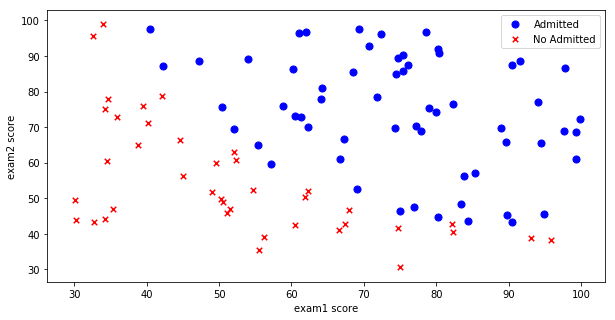

In [6]:
#原始数据录取情况进行可视化展示
positive=pdData[pdData["admitted"]==1]#被录取的学生
negative=pdData[pdData["admitted"]==0]#未被录取的学生

#作图
fig,ax=plt.subplots(figsize=(10,5))
#画散点图
#传入exam的值，s表示点的大小，c颜色,marker是标记图形
ax.scatter(positive["exam1"],positive["exam2"],s=50,c="b",marker="o",label="Admitted")#横坐标为exam1值，纵坐标为exam2的值
ax.scatter(negative["exam1"],negative["exam2"],s=30,c="r",marker="x",label="No Admitted")
ax.legend()
ax.set_xlabel("exam1 score")
ax.set_ylabel("exam2 score")

目标：建立分类器（求解出三个参数  𝜃0𝜃1𝜃2 ）

设定阈值，根据阈值判断录取结果

要完成的模块
sigmoid : 映射到概率的函数

model : 返回预测结果值

cost : 根据参数计算损失

gradient : 计算每个参数的梯度方向

descent : 进行参数更新

accuracy: 计算精度

逻辑回归

目标：建立分类器（求解出三个参数θ0,θ1,θ2,），θ0是偏置项，其余两个参数对应两个特征
设定阈值，根据阈值判断录取结果

要完成的模块：
1、sigmoid函数：映射到概率的输出函数
2、model：返回预测结果
3、cost根据参数计算损失
4、计算每个参数的梯度方向
5、参数更新
6、accuracy:计算精度



sigmoid函数：
g(z)=1/1+e^-z

In [7]:
# 1、sigmoid
def sigmoid(z):
    return 1/(1+np.exp(-z))

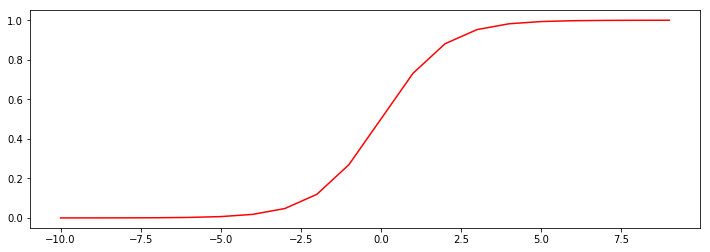

In [8]:
#sigmoid图像
nums=np.arange(-10,10,step=1)
fig,ax=plt.subplots(figsize=(12,4))
#连续曲线图
ax.plot(nums,sigmoid(nums),c="r")#横纵坐标和颜色


($\theta$0  $\theta$1  $\theta$2)x
$$\begin{pmatrix}
1\\
x1\\
x2\\
\end{pmatrix}$$
=
$\theta$0+$\theta$0x1+$\theta$2x2

In [9]:
#2、将矩阵乘积放入sigmoid函数当中
def model(X,theta):
    return sigmoid(np.dot(X,theta.T))

In [10]:
#处理样本
pdData.insert(0,"ones",1)#因为每一个样本第一个数都是1，对应θ0，用于矩阵乘法,只执行一次即可

orig_data=pdData.as_matrix()#将原始样本转化成矩阵形式
cols=orig_data.shape[1]
#cols#100行，4列的数据样本
# orig_data[:5]
#抽离出样本中的特征和标记值
#第一个：表示去所有样本，第二个：是进行属性分割
X=orig_data[:,0:cols-1]#除了最后一列，其余都取出来
y=orig_data[:,cols-1:cols]#去最后一列标记值

D:\python3.6.3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [11]:
#初始化thetaθ变量
theta=np.zeros([1,3])
X[:5]

array([[ 1.        , 34.62365962, 78.02469282],
       [ 1.        , 30.28671077, 43.89499752],
       [ 1.        , 35.84740877, 72.90219803],
       [ 1.        , 60.18259939, 86.3085521 ],
       [ 1.        , 79.03273605, 75.34437644]])

In [12]:
X.shape,y.shape, theta.shape

((100, 3), (100, 1), (1, 3))

$\mathbb {损失函数}$
$\mathbb {对数似然函数去负号，求损失函数}$

D(h$\theta$(x),y)=
    -ylog(h$\theta$(x))-(1-y)log(1-h$\theta$(x)) 

$\mathbb {平均损失}$

J($\theta$)=$\frac{1}{n}$ $\sum_{i=1}^n $ D(h$\theta$(xi),yi)

In [30]:
#损失函数
#先计算D()中的-ylog(hθ(x))
#在计算-(1-y)log(1-hθ(x))
#再代入J(θ)这个公式当中
def cost(X,y,theta):
    left=np.multiply(-y,np.log(model(X,theta)))#注意这个地方,np.log默认为以e为底数，而数学上log()默认10为底数
    right=np.multiply(1-y,np.log(1-model(X,theta)))
    Jtheta=np.sum(left-right)/len(X)
#     sig=1/(1+np.exp(np.dot(X,theta.T)))
#     print("sigmoid(-z):",sig,"np.log()",np.log(sig),"left",-y*np.log(sig))
    return Jtheta

In [31]:
# print("theta",theta)
# Jtheta=cost(X,y,theta)
# print("Jtheta",Jtheta)
cost(X,y,theta)#一开始损失比较大，需要不断优化(同时因为有sigmoid函数和np.log()函数，所以一开始θ=[0,0,0]时，损失函数也不会为0)

0.6931471805599453

$\mathtt {计算梯度}$

$\frac{\partial J}{\partial \theta j} $=
-$\frac{1}{m} $ $\sum_{i=1}^n$ (yi-h$\theta$(xi))$x_i^j$

In [13]:
theta
# len(theta.shape)

array([[0., 0., 0.]])

In [14]:
#根据上面的公式计算梯度,就是对比着上面的梯度计算公式写代码
def gradient(X,y,theta):
    grad=np.zeros(theta.shape)#有几个θ就该有几个梯度，因为需要分别优化
    error=(model(X,theta)-y).ravel()#计算-(yi-hθ(xi)),即误差
    #对每一个theta求偏导
    for j in range(len(theta.ravel())):
        #计算-(yi-hθ(xi))与xij的乘积
        term=np.multiply(error,X[:,j])#X[:,j]第一个：表示取所有样本,j表示取第j列，因为对第j个特征求θ参数
        #计算梯度
        grad[0,j]=np.sum(term)/len(X)#梯度是一个[[θ0，θ1，θ2]]这样的一行三列结构，故用grad[0,j]表示
    return grad#这个地方第一次写错了，将return放在了for循环里面，导致theta1和theta2的梯度一直为0，影响后续结果


    

In [15]:
g=gradient(X,y,theta)
g

array([[ -0.1       , -12.00921659, -11.26284221]])

$$\mathtt{三种梯度下降方法的比较}$$

$\mathtt{一、批量梯度下降(会使用所有的样本，容易得到最优解，但速度较慢)}$

$\mathtt{二、随机梯度下降(每次只找一个样本，迭代速度快，但不容易收敛)}$

$\mathtt{三、小批量梯度下降(每次选择一部分数据，较为实用)}$

In [16]:
STOP_ITER=0#按照迭代次数选择停止.指定迭代次数阈值，超过次数就停止
STOP_COST=1#按照损失函数，指定损失函数阈值，作为指标
STOP_GRAD=2#按照梯度，指定梯度的阈值，作为停止的指标

def stopCriterion(type,value,threshold):
    if type=="STOP_ITER":     return value>threshold
    elif type=="STOP_COST":    return abs(value[-1]-value[-2])<threshold
    elif type=="STOP_GRAD":    return np.linalg.norm(value)<threshold#范数

In [17]:
#数据洗牌，打乱顺序
import random
def shuffleData(data):
    np.random.shuffle(data)
    #data.shape()返回(a,b)元组结构，分别表示样本数目和列数
    cols=data.shape[1]#样本列的数目
    X=data[:,0:cols-1]#取出所有的特征列样本,注意不要写成data[:,cols-1]，这样只能取一列，有过一次错误了
    y=data[:,cols-1:cols]#取出标记列样本
    return X,y


In [18]:
#梯度下降的代码实现
import time
def descent(data,theta,batchSize,stopType,thresh,alpha):
    print("进入descent函数")
    init_time=time.time()
    i=0#迭代次数
    k=0#batch
    X,y=shuffleData(data)#数据洗牌
    grad=np.zeros(theta.shape)#梯度初始化
    costs=[cost(X,y,theta)]#损失值
    value=0
    while True:
#         print("第%s次迭代" %(i))
        grad=gradient(X[k:k+batchSize],y[k:k+batchSize],theta)
        k+=batchSize
        if k>=n:
            k=0
            X,y=shuffleData(data)#重新洗牌
        theta=theta-alpha*grad#参数更新
        costs.append(cost(X,y,theta))#不断更新损失值
        i+=1#一次迭代完成
#         print(grad)
        
        if stopType=="STOP_ITER":      value=i
        elif stopType=="STOP_COST":    value=costs
        elif stopType=="STOP_GRAD":    value=grad
        if  stopCriterion(stopType,value,thresh):break
    return theta,i-1,costs,grad
    #,i-1,costs,grad,time.time()-init_time()
    

In [19]:
def runExpe(data, theta, batchSize, stopType, thresh, alpha):
    print("进入runExpe函数")
    #import pdb; pdb.set_trace();
    theta, iter, costs, grad = descent(data, theta, batchSize, stopType, thresh, alpha)#, dur
    name = "Original" if (data[:,1]>2).sum() > 1 else "Scaled"
    name += " data - learning rate: {} - ".format(alpha)
    if batchSize==n: strDescType = "Gradient"
    elif batchSize==1:  strDescType = "Stochastic"
    else: strDescType = "Mini-batch ({})".format(batchSize)
    name += strDescType + " descent - Stop: "
    if stopType == STOP_ITER: strStop = "{} iterations".format(thresh)
    elif stopType == STOP_COST: strStop = "costs change < {}".format(thresh)
    else: strStop = "gradient norm < {}".format(thresh)
    name += strStop
    print ("***{}\nTheta: {} - Iter: {} - Last cost: {:03.2f} ".format(
        name, theta, iter, costs[-1]))
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(np.arange(len(costs)), costs, 'r')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title(name.upper() + ' - Error vs. Iteration')
    return theta

$\mathtt {不同的停止策略}$

$\mathtt {设定不同的迭代次数}$

In [20]:
#选择基于所有样本的梯度下降方法
n=100
# runExpe(orig_data, theta, n, "STOP_ITER", thresh=50000, alpha=0.000001)


$\mathtt {根据损失值停止}$

In [21]:
# runExpe(orig_data, theta, n, "STOP_COST", thresh=0.000001, alpha=0.001)

$\mathtt {根据梯度变化停止}$

In [22]:
# runExpe(orig_data,theta,n,"STOP_GRAD",thresh=0.05,alpha=0.001)
#注意alpha=0.001，第一次设置为了0.01导致梯度爆炸了，没有收敛，所以学习率还是小一点好

$\mathtt {对比三种批量的梯度下降方法}$

$\mathtt {一次只选取一个样本}$

In [23]:
# runExpe(orig_data,theta,1,"STOP_ITER",thresh=5000,alpha=0.001)

$\mathtt {迭代不稳定   不会收敛}$

进入runExpe函数
进入descent函数
***Original data - learning rate: 2e-06 - Stochastic descent - Stop: gradient norm < 15000
Theta: [[-0.00202187  0.0099863   0.00092249]] - Iter: 15000 - Last cost: 0.63 


array([[-0.00202187,  0.0099863 ,  0.00092249]])

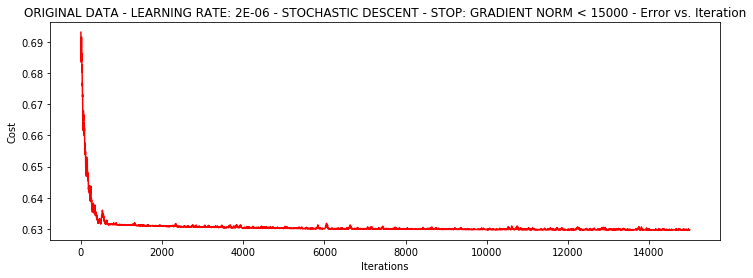

In [24]:
runExpe(orig_data,theta,1,"STOP_ITER",thresh=15000,alpha=0.000002)

增加迭代次数  并且减小了学习率，开始稳定一些了，并趋于收敛但瘦脸效果还是不好


$\mathtt {基于mini-batch的梯度下降}$

$\mathtt {每次会抽取一部分样本进行训练，时间消耗不大并且损失函数也会收敛效果更好}$

进入runExpe函数
进入descent函数
***Original data - learning rate: 0.001 - Mini-batch (16) descent - Stop: gradient norm < 15000
Theta: [[-1.03186465  0.03557148  0.01575006]] - Iter: 15000 - Last cost: 0.79 


array([[-1.03186465,  0.03557148,  0.01575006]])

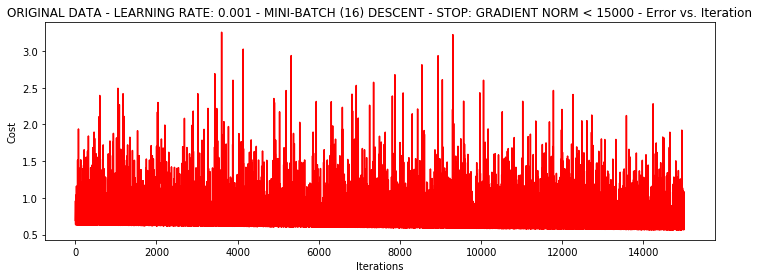

In [25]:
runExpe(orig_data,theta,16,"STOP_ITER",thresh=15000,alpha=0.001)

数据浮动仍然较大，我们来尝试一下对数据进行标准化处理。将数据按照其属性(按列进行)减去其均值，然后除以其方差。最后得到的结果是，
对每个属性(每列)来说所有的数据都聚集在0附近，方差值为1

进入runExpe函数
进入descent函数
***Scaled data - learning rate: 0.001 - Gradient descent - Stop: gradient norm < 5000
Theta: [[0.3080807  0.86494967 0.77367651]] - Iter: 5000 - Last cost: 0.38 


array([[0.3080807 , 0.86494967, 0.77367651]])

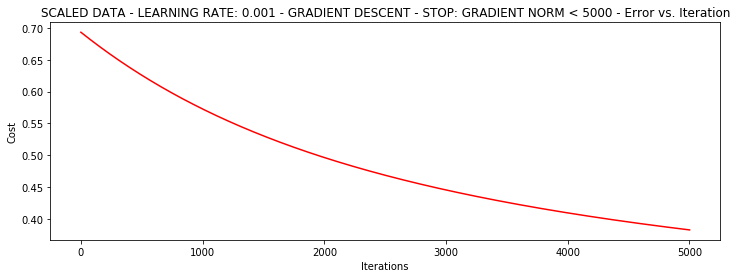

In [26]:
#数据处理
from sklearn import preprocessing as pp

scaled_data = orig_data.copy()
scaled_data[:, 1:3] = pp.scale(orig_data[:, 1:3])#数据标准化处理

#再跑一次实验
runExpe(scaled_data, theta, n, "STOP_ITER", thresh=5000, alpha=0.001)


In [27]:
可以发现，经过数据的预处理之后，损失值已经讲到0.4了，收敛效果相比较来说好很多了

进入runExpe函数
进入descent函数
***Scaled data - learning rate: 0.001 - Mini-batch (16) descent - Stop: gradient norm < 0.002
Theta: [[1.23065813 2.97777757 2.73659411]] - Iter: 91062 - Last cost: 0.21 


array([[1.23065813, 2.97777757, 2.73659411]])

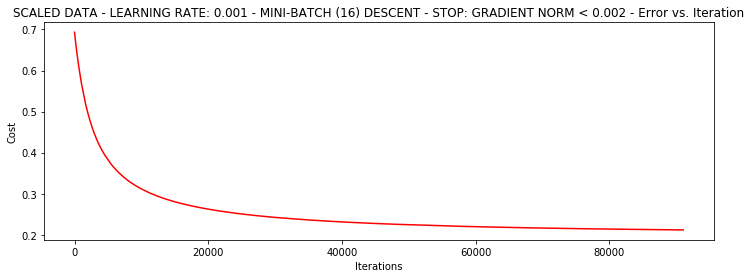

In [28]:
runExpe(scaled_data, theta, 16, "STOP_GRAD", thresh=0.002, alpha=0.001)

可以看出，经过预处理后的数据，采用mini-batch加梯度下降策略，可以收敛到0.2的效果了
数据预处理真是太重要了

$\mathtt {精度}$

In [34]:
#设定阈值，并基于sigmoid函数进行分类预测
def predict(X,theta):
#     print("predict",model(X,theta))
    return [ 1 if i>=0.5 else 0 for i in model(X,theta)]

进入runExpe函数
进入descent函数
***Scaled data - learning rate: 0.001 - Mini-batch (16) descent - Stop: gradient norm < 0.002
Theta: [[1.23416762 2.97731652 2.7362226 ]] - Iter: 2519 - Last cost: 0.21 
预测结果
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]
精度是0.89%


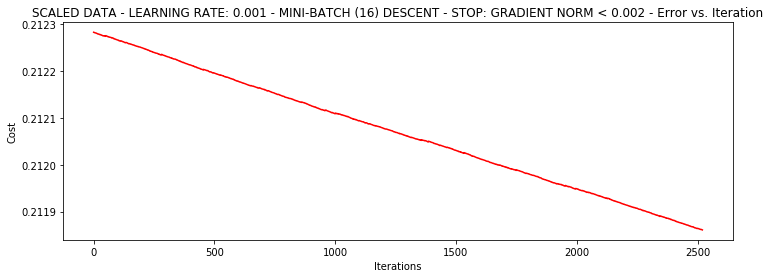

In [35]:
theta=runExpe(scaled_data, theta, 16, "STOP_GRAD", thresh=0.002, alpha=0.001)
scaled_x=scaled_data[:,:3]
scaled_y=scaled_data[:,3]
predictions=predict(scaled_x,theta)
correct=[      1  if(p==1 and y==1) or (p==0 and y==0)   else 0  for (p,y) in zip(predictions,scaled_y)]
print("预测结果")
print(correct)
accuracy=sum(map(int ,correct))/len(correct)
print("精度是{0}%".format(accuracy))